In [1]:
import argparse
import pandas as pd
import numpy as np
from numpy import savez_compressed, load
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from functools import reduce
en_stopwords = set(stopwords.words('english')) 
import itertools
import re
import time
import os
import pickle

import datasets
from datasets import load_dataset, load_metric, Dataset, concatenate_datasets,DatasetDict
from datasets import load_from_disk
from tqdm import tqdm
tqdm.pandas(position=0,leave=True)


import textwrap

import transformers

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    get_linear_schedule_with_warmup,
)
print("Transformers version is {}".format(transformers.__version__))

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display, HTML

sns.set(style="whitegrid",palette='muted',font_scale=1.2)
rcParams['figure.figsize']=16,10

%config InlineBackend.figure_format="retina"
%matplotlib inline

pd.set_option('display.max_columns', None,'display.max_rows',None)

Transformers version is 4.6.1


Matplotlib is building the font cache; this may take a moment.


In [2]:
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all

DatasetDict({
    train: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 99270
    })
    test: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 27300
    })
})

In [17]:
train_data=email_all['train']
test_data=email_all['test']
train_data.set_format(type="pandas")
df_train=train_data[:]
test_data.set_format(type="pandas")
df_test=test_data[:]

In [18]:
tempt1=pd.DataFrame(df_train["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_train["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Training set churn dist")

,churn,count,percentage
0,0,"88,500",89.15%
1,1,"10,770",10.85%


In [19]:
tempt1=pd.DataFrame(df_test["churn"].value_counts(dropna=False)).reset_index().rename(columns={'index':'churn','churn':'count'})
tempt2=pd.DataFrame(df_test["churn"].value_counts(dropna=False,normalize=True)).reset_index().rename(columns={'index':'churn','churn':'percentage'})
tempt1.merge(tempt2, on="churn", how="inner").style.format({'count':'{:,}','percentage':'{:.2%}'}).set_caption("Test set churn dist")

,churn,count,percentage
0,0,"23,100",84.62%
1,1,"4,200",15.38%


In [20]:
df_train.head()

,Full_TextBody,Client_TextBody,Latest_TextBody,year,churn
0,good morning nicholas smith has been off work ...,good morning nicholas smith has been off work ...,good morning nicholas smith has been off work ...,2021,0
1,"good afternoon crystal, ive attached the janua...","good afternoon crystal, ive attached the janua...","hello unum, thank you for the attached. my com...",2020,0
2,"good morning, i need help in getting my compan...","good morning, i need help in getting my compan...",", , , , hi lebreda, thank you for contacting a...",2021,1
3,this message originated outside of unum. use c...,this message originated outside of unum. use c...,"hello laurie, thank you for contacting ask unu...",2019,0
4,darcy bourgault client name dfd russell medica...,darcy bourgault client name dfd russell medica...,"hello, can you please send me a copy of the ev...",2021,0


In [22]:
from datasets import Dataset
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)

In [23]:
train_df1=Dataset.from_pandas(df_train)
train_df1=train_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

test_df1=Dataset.from_pandas(df_test)
test_df1=test_df1.map(lambda x: tokenizer(x["Full_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df1=train_df1.map(compute_lenth)
test_df1=test_df1.map(compute_lenth)

  0%|          | 0/100 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5626 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/99270 [00:00<?, ?ex/s]

  0%|          | 0/27300 [00:00<?, ?ex/s]

In [25]:
train_df2=Dataset.from_pandas(df_train)
train_df2=train_df2.filter(lambda x: x["Client_TextBody"]!=None)
train_df2=train_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

test_df2=Dataset.from_pandas(df_test)
test_df2=test_df2.filter(lambda x: x["Client_TextBody"]!=None)
test_df2=test_df2.map(lambda x: tokenizer(x["Client_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df2=train_df2.map(compute_lenth)
test_df2=test_df2.map(compute_lenth)

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/92 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/26 [00:00<?, ?ba/s]

  0%|          | 0/91550 [00:00<?, ?ex/s]

  0%|          | 0/25450 [00:00<?, ?ex/s]

In [26]:
train_df3=Dataset.from_pandas(df_train)
train_df3=train_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

test_df3=Dataset.from_pandas(df_test)
test_df3=test_df3.map(lambda x: tokenizer(x["Latest_TextBody"]),batched=True)

def compute_lenth(example):
    return {"text_length":len(example["input_ids"])}
train_df3=train_df3.map(compute_lenth)
test_df3=test_df3.map(compute_lenth)

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/99270 [00:00<?, ?ex/s]

  0%|          | 0/27300 [00:00<?, ?ex/s]

In [30]:
def statistics_compute(hf_df1,hf_df2,p=1):

    X=[]
    X.append(np.percentile(hf_df1['text_length'],p))
    X.append(np.percentile(hf_df2['text_length'],p))
    
    result={}
    result['percentile']=X
    result["min"]=[np.min(hf_df1['text_length']),np.min(hf_df2['text_length'])]
    result["max"]=[np.max(hf_df1['text_length']),np.max(hf_df2['text_length'])]
    result["mean"]=[np.mean(hf_df1['text_length']),np.mean(hf_df2['text_length'])]
    return result

def statistics_table(hf_df1,hf_df2):
    dict_data={}
    dict_data["data_type"]=["training", "test"]
    dict_data["# of obs"]=[len(hf_df1['text_length']),len(hf_df2['text_length'])]
    dict_data["Min of tokens"]=statistics_compute(hf_df1, hf_df2)["min"]
    dict_data["1% of tokens"]=statistics_compute(hf_df1, hf_df2, p=1)['percentile']
    dict_data["5% of tokens"]=statistics_compute(hf_df1, hf_df2, p=5)['percentile']
    dict_data["10% of tokens"]=statistics_compute(hf_df1, hf_df2, p=10)['percentile']
    dict_data["25% of tokens"]=statistics_compute(hf_df1, hf_df2, p=25)['percentile']
    dict_data["Median of tokens"]=statistics_compute(hf_df1, hf_df2, p=50)['percentile']
    dict_data["Average tokens"]=statistics_compute(hf_df1, hf_df2)["mean"]
    dict_data["75% of tokens"]=statistics_compute(hf_df1, hf_df2, p=75)['percentile']
    dict_data["90% of tokens"]=statistics_compute(hf_df1, hf_df2, p=90)['percentile']
    dict_data["95% of tokens"]=statistics_compute(hf_df1, hf_df2, p=95)['percentile']
    dict_data["99% of tokens"]=statistics_compute(hf_df1, hf_df2, p=99)['percentile']
    dict_data["Max of tokens"]=statistics_compute(hf_df1, hf_df2)["max"]
    token_count_df=pd.DataFrame(dict_data)
    return token_count_df

def style_format(token_count_df,  textbody="Full_TextBody"):
    token_count_df=token_count_df.set_index("data_type")
    token_count_df[list(token_count_df.columns)] = token_count_df[list(token_count_df.columns)].astype(int)
    return token_count_df.style.format("{:,}").set_caption(f"Summary Statistics of token lengths for {textbody} ").set_table_styles([{
        'selector': 'caption',
        'props': [
            ('color', 'red'),
            ('font-size', '20px')
        ]
    }])

In [32]:
token_count_df=statistics_table(train_df1,test_df1)
style_format(token_count_df,  textbody="Full_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"99,270",14,107,157,215,409,944,"1,728","2,045","3,997","5,598","11,803","71,627"
test,"27,300",21,127,176,228,439,"1,062","1,973","2,445","4,575","7,006","13,853","24,263"


In [33]:
token_count_df=statistics_table(train_df2,test_df2)
style_format(token_count_df,  textbody="Client_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"91,550",3,25,54,82,179,418,785,959,"1,782","2,645","4,785","27,104"
test,"25,450",4,24,55,85,177,437,876,"1,073","2,052","3,074","6,661","11,942"


In [34]:
token_count_df=statistics_table(train_df3,test_df3)
style_format(token_count_df,  textbody="Latest_TextBody")

,# of obs,Min of tokens,1% of tokens,5% of tokens,10% of tokens,25% of tokens,Median of tokens,Average tokens,75% of tokens,90% of tokens,95% of tokens,99% of tokens,Max of tokens
data_type,,,,,,,,,,,,,
training,"99,270",3,14,83,118,181,397,696,821,"1,540","2,156","4,510","31,936"
test,"27,300",3,30,117,145,218,477,846,"1,020","1,954","2,666","5,747","12,238"


In [35]:
from datasets import Dataset
hf_train=Dataset.from_pandas(df_train)
hf_test=Dataset.from_pandas(df_test)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_train=hf_train.map(lambda x : tokenizer(x[text]),batched=True)
    hf_train=hf_train.remove_columns("attention_mask")
    hf_train=hf_train.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)
    
    hf_test=hf_test.map(lambda x : tokenizer(x[text]),batched=True)
    hf_test=hf_test.remove_columns("attention_mask")
    hf_test=hf_test.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")


  0%|          | 0/100 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (5626 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/100 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [38]:
hf_train.set_format(type="pandas")
df_train=hf_train[:]

hf_test.set_format(type="pandas")
df_test=hf_test[:]

In [39]:
df_train.columns

Index(['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn',
       'Full_TextBody_input_ids', 'Latest_TextBody_input_ids'],
      dtype='object')

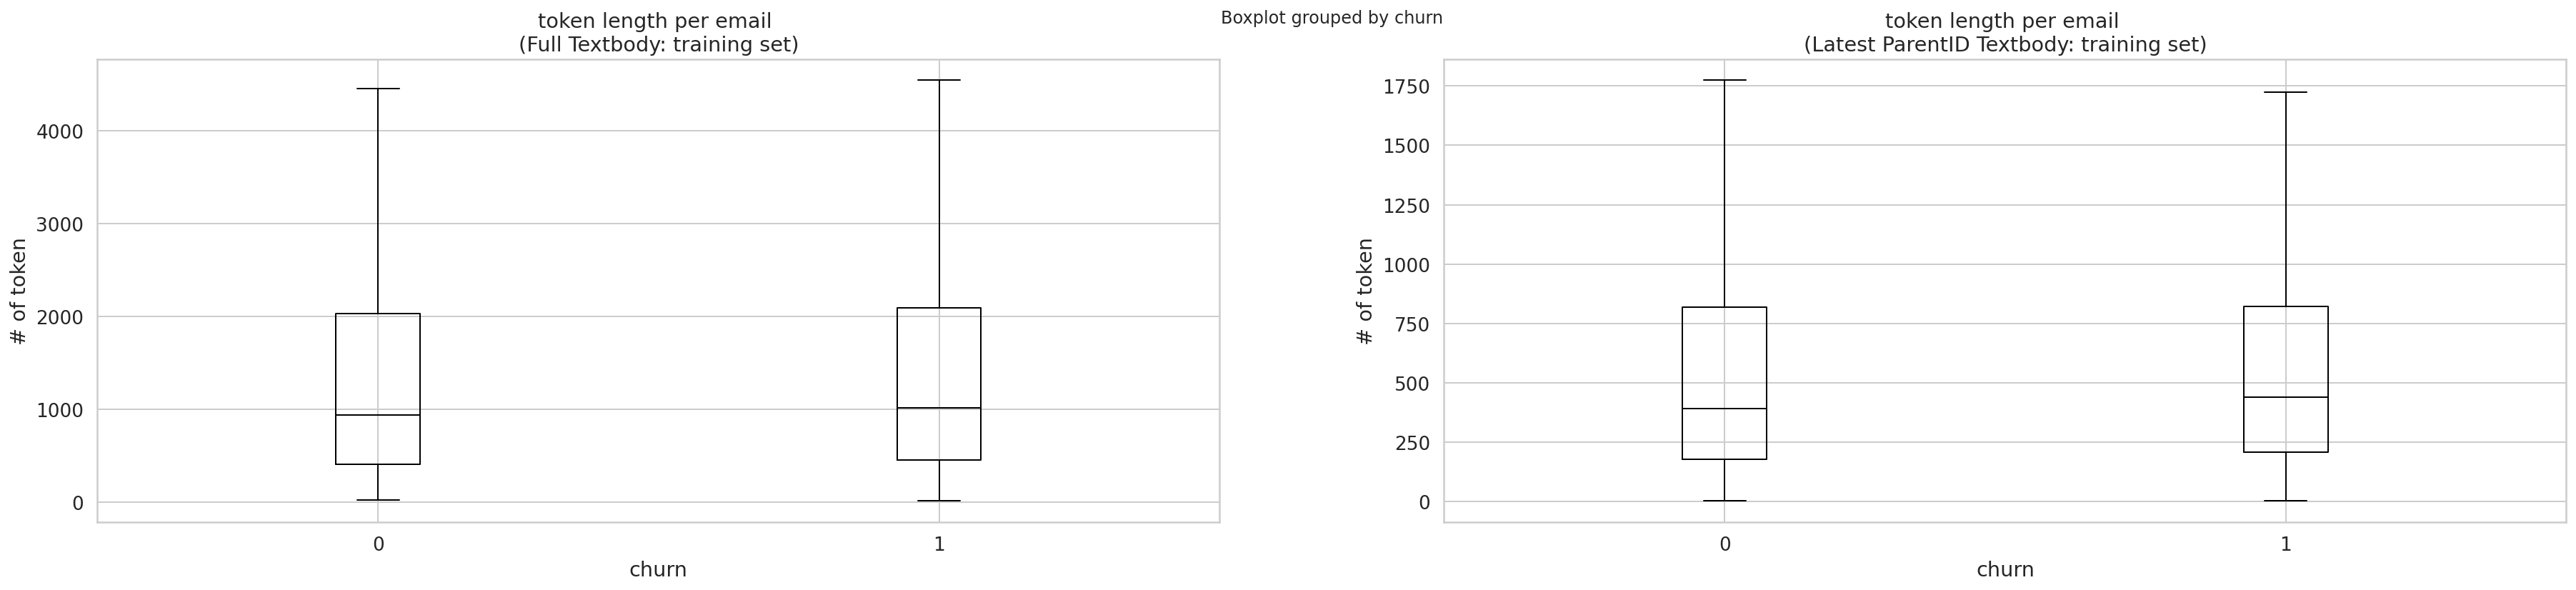

In [40]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df_train["Full_Words_length"] = df_train["Full_TextBody_input_ids"].apply(len)
df_train.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Full Textbody: training set)")
ax1.set_ylabel("# of token")
df_train["latest_Words_length"] = df_train["Latest_TextBody_input_ids"].apply(len)
df_train.boxplot("latest_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Latest ParentID Textbody: training set)")
ax2.set_ylabel("# of token")
plt.show()

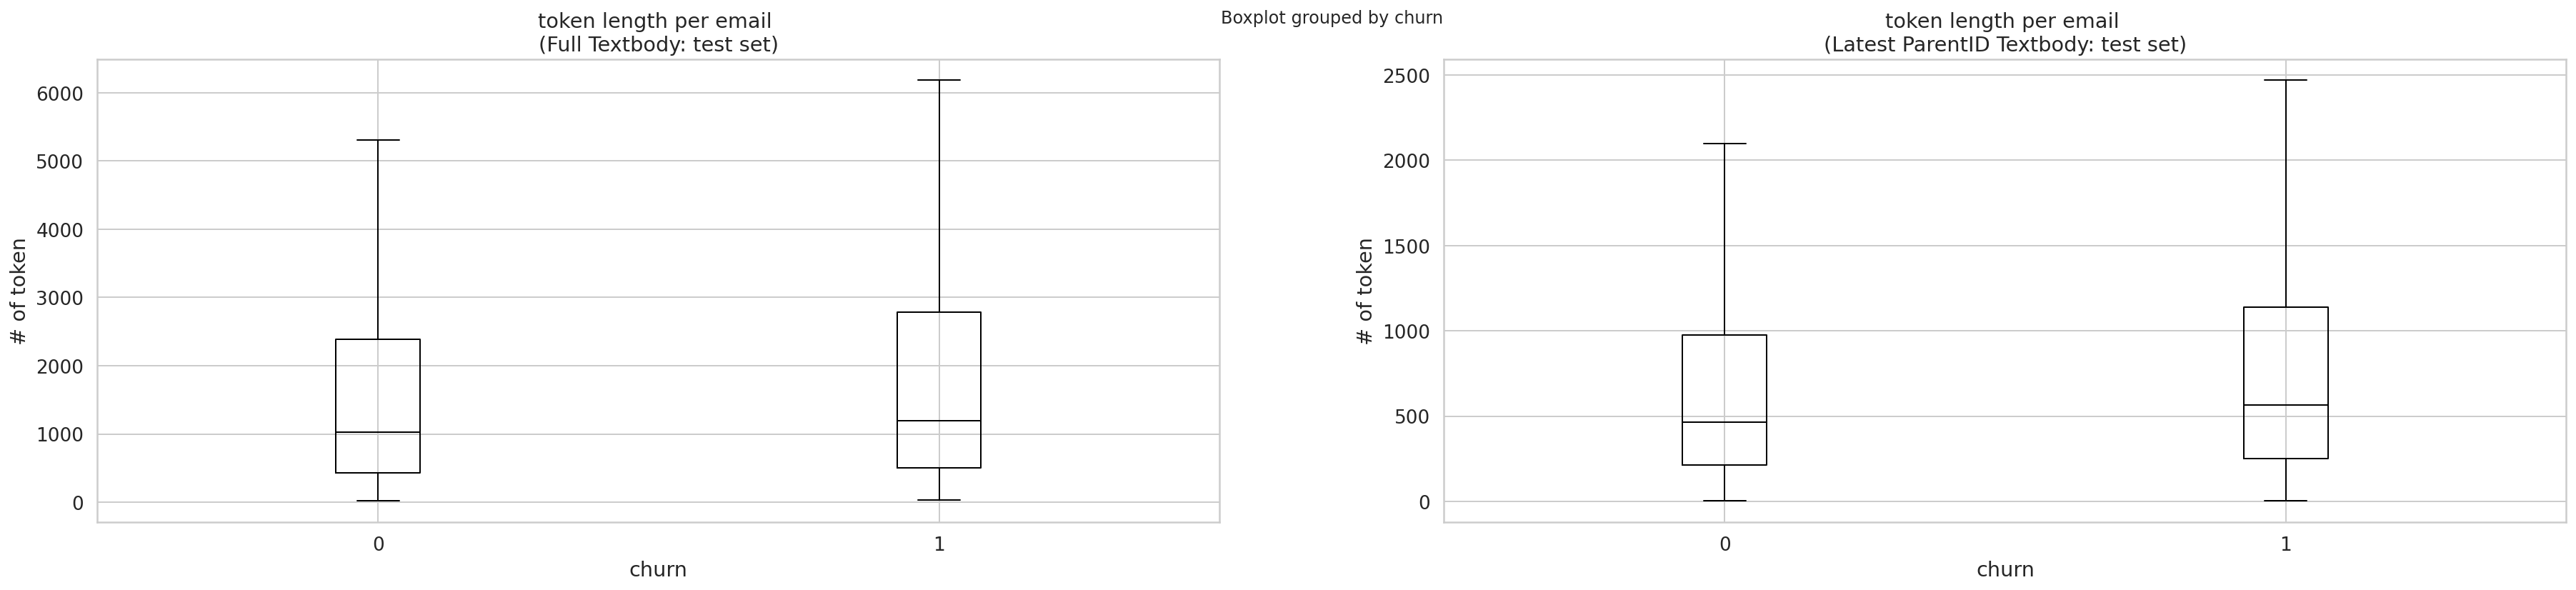

In [41]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df_test["Full_Words_length"] = df_test["Full_TextBody_input_ids"].apply(len)
df_test.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Full Textbody: test set)")
ax1.set_ylabel("# of token")
df_test["latest_Words_length"] = df_test["Latest_TextBody_input_ids"].apply(len)
df_test.boxplot("latest_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Latest ParentID Textbody: test set)")
ax2.set_ylabel("# of token")
plt.show()

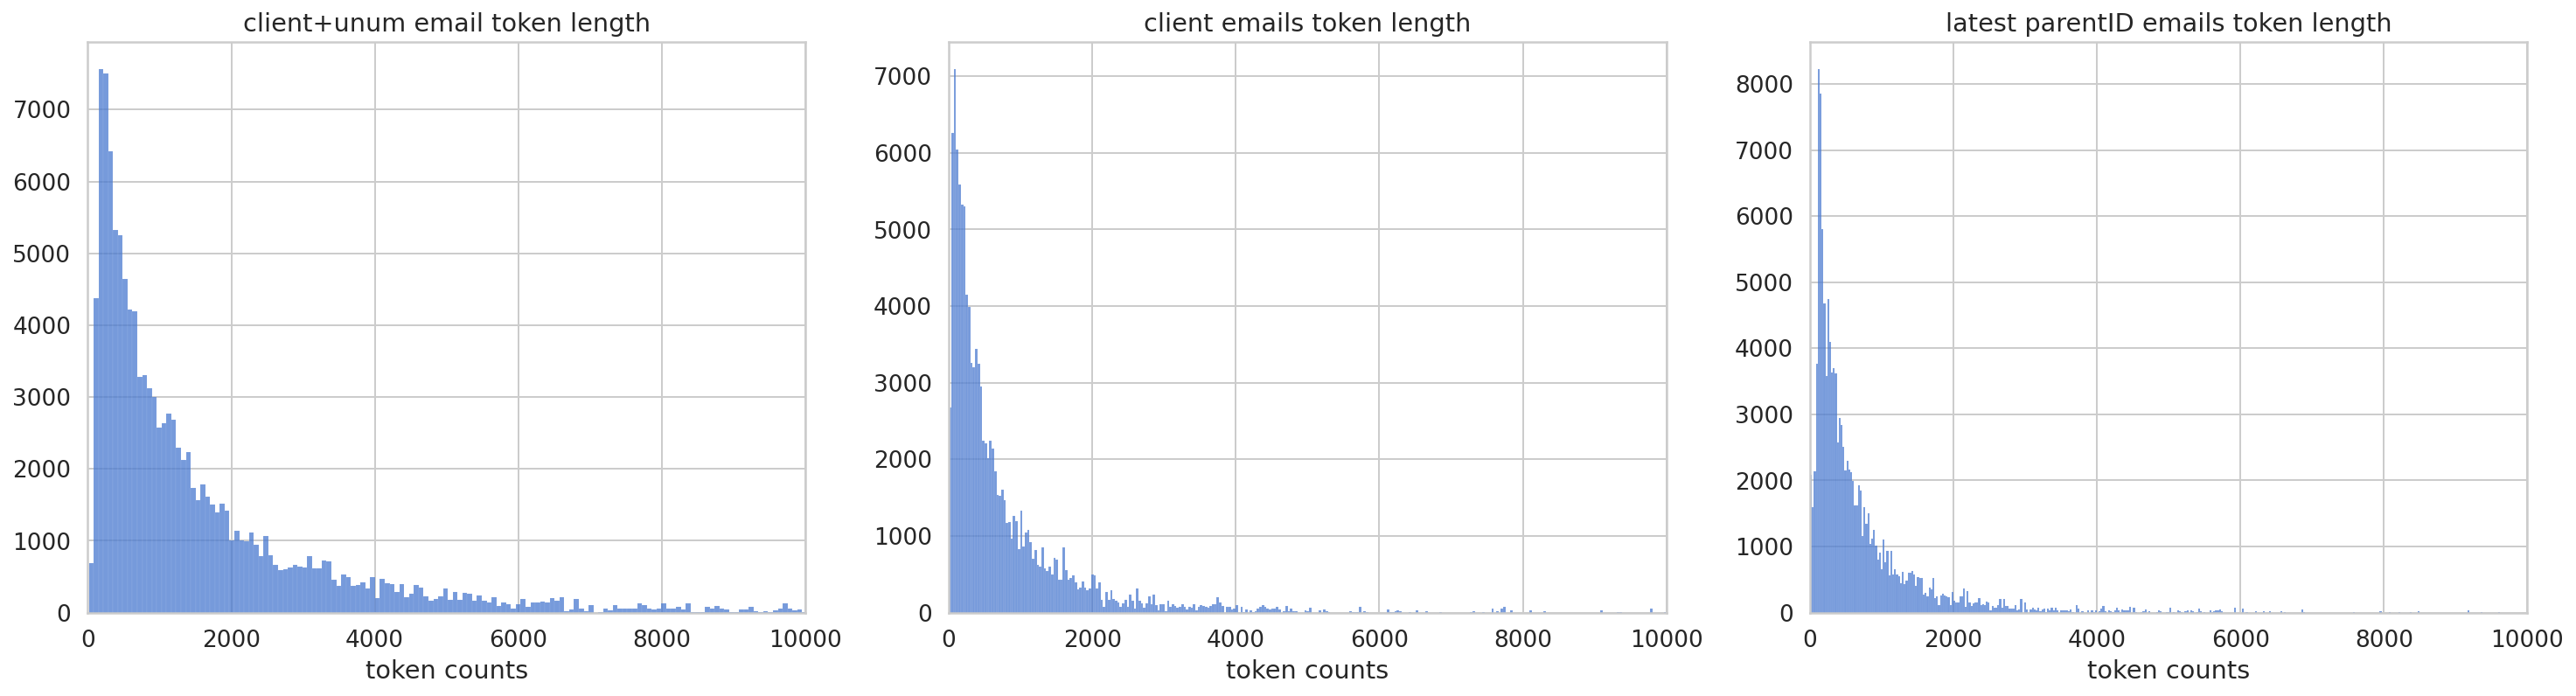

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3, figsize=(25,6))
sns.histplot(hf_df1['text_length'],ax=ax1)
ax1.set_title("client+unum email token length")
ax1.set_xlabel("token counts")
ax1.set_ylabel("")
ax1.set(xlim=(0, 10000))

sns.histplot(hf_df2['text_length'],ax=ax2)
ax2.set_title("client emails token length")
ax2.set_xlabel("token counts")
ax2.set_ylabel("")
ax2.set(xlim=(0, 10000))

sns.histplot(hf_df3['text_length'],ax=ax3)
ax3.set_title("latest parentID emails token length")
ax3.set_xlabel("token counts")
ax3.set_ylabel("")
ax3.set(xlim=(0, 10000))
plt.show()

In [13]:
hf_df3

Dataset({
    features: ['unum_id', 'policy_id', 'pivot_date', 'year', 'month', 'start_date', 'end_date', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'churn', '__index_level_0__', 'input_ids', 'attention_mask', 'text_length'],
    num_rows: 126570
})

In [18]:
churn_text_pickle.columns

Index(['unum_id', 'policy_id', 'pivot_date', 'year', 'month', 'start_date',
       'end_date', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody',
       'churn'],
      dtype='object')

In [20]:
from datasets import Dataset
hf_dataset=Dataset.from_pandas(churn_text_pickle)
model_checkpoint="allenai/longformer-base-4096"
tokenizer=AutoTokenizer.from_pretrained(model_checkpoint)
        
for text in ["Full_TextBody", "Latest_TextBody"]:
    hf_dataset=hf_dataset.map(lambda x : tokenizer(x[text]),batched=True)
    hf_dataset=hf_dataset.remove_columns("attention_mask")
    hf_dataset=hf_dataset.rename_column(original_column_name="input_ids", new_column_name=text+"_input_ids")
    # hf_dataset = hf_dataset.filter(lambda x: len(x[text+"_input_ids"]) > self.min_tokens)


  0%|          | 0/127 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4629 > 4096). Running this sequence through the model will result in indexing errors


  0%|          | 0/127 [00:00<?, ?ba/s]

In [21]:
hf_dataset

Dataset({
    features: ['unum_id', 'policy_id', 'pivot_date', 'year', 'month', 'start_date', 'end_date', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'churn', '__index_level_0__', 'Full_TextBody_input_ids', 'Latest_TextBody_input_ids'],
    num_rows: 126570
})

In [25]:
hf_dataset=hf_dataset.remove_columns("__index_level_0__")
hf_dataset.set_format(type="pandas")
df=hf_dataset[:]
df.head()

,unum_id,policy_id,pivot_date,year,month,start_date,end_date,Full_TextBody,Client_TextBody,Latest_TextBody,churn,Full_TextBody_input_ids,Latest_TextBody_input_ids
0,167996771,403751,2022-01-01,2022,1,2021-07-01,2021-10-01,"hello courtney, as discussed, i have included ...","hi, we have a new hr coordinator beginning on ...","hello courtney, as discussed, i have included ...",0,"[0, 42891, 461, 2596, 6, 25, 3373, 6, 939, 33,...","[0, 42891, 461, 2596, 6, 25, 3373, 6, 939, 33,..."
1,167996771,403751,2021-01-01,2021,1,2020-07-01,2020-10-01,"city of niagara falls, ny hello toni, thank yo...",none of these are similar to the previous invo...,"city of niagara falls, ny hello my unum team, ...",0,"[0, 14853, 9, 10265, 45282, 5712, 6, 295, 219,...","[0, 14853, 9, 10265, 45282, 5712, 6, 295, 219,..."
2,167996771,403751,2020-01-01,2020,1,2019-07-01,2019-10-01,please remove kathleen green from this corresp...,please remove kathleen green from this corresp...,au team please process this and confirm. thank...,0,"[0, 37111, 3438, 449, 2681, 17733, 2272, 31, 4...","[0, 1180, 165, 2540, 609, 42, 8, 4559, 4, 2446..."
3,167994141,515015,2022-04-01,2022,4,2021-10-01,2022-01-01,"good morning, i have been trying since to log ...","good morning, i have been trying since to log ...","hello linda, thank you for contacting ask unum...",0,"[0, 8396, 662, 6, 939, 33, 57, 667, 187, 7, 74...","[0, 42891, 784, 8865, 6, 3392, 47, 13, 20896, ..."
4,167968485,404280,2020-06-01,2020,6,2019-12-01,2020-03-01,"hello, can you confirm if you have received a ...","hello, can you confirm if you have received a ...","hi wendy, thank you for your email. we have no...",0,"[0, 42891, 6, 64, 47, 4559, 114, 47, 33, 829, ...","[0, 3592, 885, 1397, 219, 6, 3392, 47, 13, 110..."


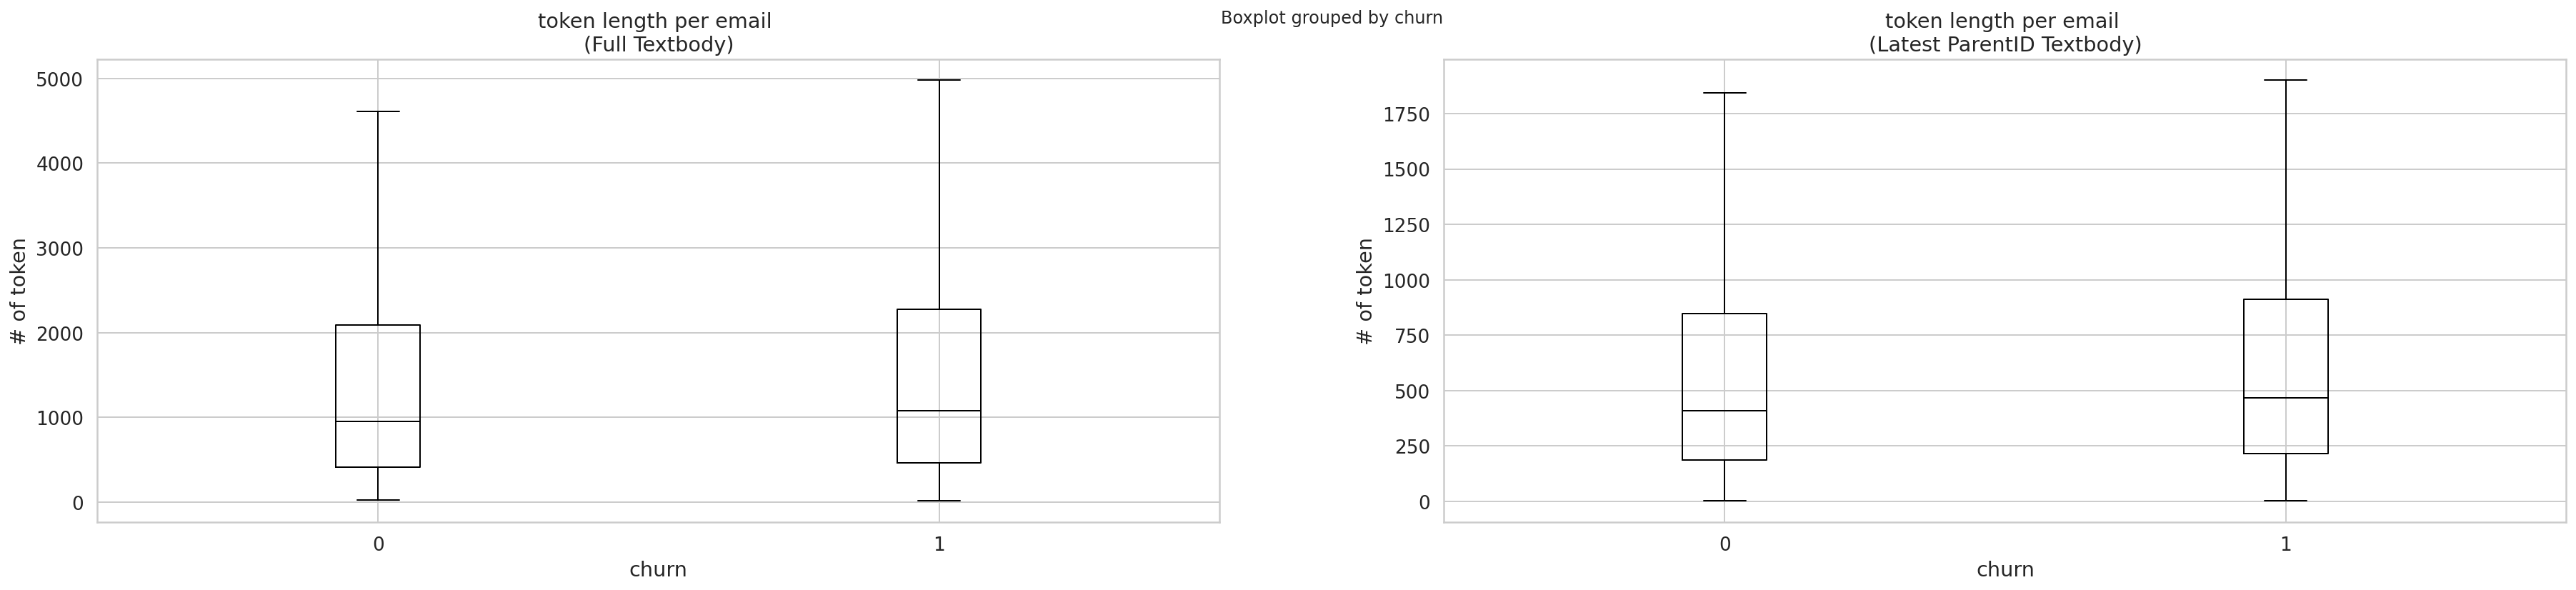

In [27]:
fig,(ax1,ax2)=plt.subplots(1,2, figsize=(30,6))
df["Full_Words_length"] = df["Full_TextBody_input_ids"].apply(len)
df.boxplot("Full_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax1)
ax1.set_title("token length per email \n(Full Textbody)")
ax1.set_ylabel("# of token")
df["latest_Words_length"] = df["Latest_TextBody_input_ids"].apply(len)
df.boxplot("latest_Words_length", by="churn", grid=True, showfliers=False,color="black",ax=ax2)
ax2.set_title("token length per email \n(Latest ParentID Textbody)")
ax2.set_ylabel("# of token")
plt.show()

In [28]:
hf_df1

Dataset({
    features: ['unum_id', 'policy_id', 'pivot_date', 'year', 'month', 'start_date', 'end_date', 'Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'churn', '__index_level_0__', 'input_ids', 'attention_mask', 'text_length'],
    num_rows: 126570
})

In [29]:
usecols=['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year','churn']
email_df=churn_text_pickle.loc[:,usecols]
email_df_train=email_df[email_df['year']!=2022]
email_df_test=email_df[email_df['year']==2022]

In [63]:
from datasets import Dataset
hf_dataset=Dataset.from_pandas(email_df_train)
hf_dataset=hf_dataset.remove_columns('__index_level_0__')
hf_split=hf_dataset.train_test_split(train_size=0.9, seed=101)
hf_split["validation"]=hf_split.pop("test")
hf_test=Dataset.from_pandas(email_df_test)
hf_test=hf_test.remove_columns('__index_level_0__')
hf_split["test"]=hf_test

In [64]:
hf_split

DatasetDict({
    train: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 89343
    })
    validation: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 9927
    })
    test: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 27300
    })
})

In [65]:
hf_data=concatenate_datasets([hf_split["train"],  hf_split["validation"]],split="train")
hf_data=DatasetDict({"train":hf_data, "test":hf_split.pop('test')})
hf_data

DatasetDict({
    train: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 99270
    })
    test: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 27300
    })
})

In [66]:
hf_data.save_to_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all=load_from_disk(os.path.join(os.getcwd(),"dataset","email_all"))
email_all

Flattening the indices:   0%|          | 0/100 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 99270
    })
    test: Dataset({
        features: ['Full_TextBody', 'Client_TextBody', 'Latest_TextBody', 'year', 'churn'],
        num_rows: 27300
    })
})

In [53]:
import textwrap
import random

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=150) 

exam_1 = df["Full_TextBody"]
exam_2 = df["Client_TextBody"]
exam_3 = df["Latest_TextBody"]

# Randomly choose some examples.
for i in range(3):
    random.seed(101+i)
    j = random.choice(exam_1.index)
    
    print('')
    print("*"*50)
    print('*********  Full TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_1[j]))
    print('')
    print("*"*50)
    print('*********  Client TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_2[j]))
    print('')
    print("*"*50)
    print('*********  Latest Parent_ID TextBody ********')
    print("*"*50)
    print('')
    print(wrapper.fill(exam_3[j]))
    print('')
    print("*"*200)


**************************************************
*********  Full TextBody ********
**************************************************

policy three rivers workforce investment board hello wendy, hope you are having a good day thank you for calling us today. it was a pleasure speaking
with you attached is the spreadsheet comparing the differences in premium after making the salary updates. it has been my pleasure assisting you.
please let us know if you have any questions or if there is anything else we can do to assist you. have a wonderful day thank you, caryn lynn service
specialist client success organization askunum askunumunum.com mailtoaskunumunum.com unum covid response click here httpsbit.lycjrbm how to file a
claim online click here httpsbit.lyygqmvq we appreciate the opportunity to meet your benefit needs. if you have any questions, we have experienced
service specialists available to help you monday through friday, a.m. to p.m. eastern time. refdgrzm.xioref.hello wendy, t